# Config

In [21]:
# Data analysis and wrangling
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge

# Data

In [39]:
# mmm_input.csv를 읽어와서 학습에 필요없는 열인 H2/CH4를 제거
df = pd.read_csv("mmm_input.csv")
# df.style.hide_index()  # 이거 pandas version 1.4 이상부턴 deprecated돼서 고쳐야함 일단 keep
df.drop(["H2/CH4"], axis=1, inplace=True)

# MMM column을 분리해서 output data를 생성
x_data = df.loc[:, ["Inorganic", "Polymer"]]
y_data = df.loc[:, ["MMM"]]

C:\Users\sukam\AppData\Local\Temp\ipykernel_19832\1737026879.py:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  df.style.hide_index()


In [40]:
x_data.head()

,Inorganic,Polymer
0,280.0,154.00
1,280.0,201.00
2,280.0,0.13
3,280.0,20.00
4,280.0,5.55


In [24]:
y_data.head()

,MMM
0,227.333333
1,269.345894
2,0.246885
3,35.625000
4,10.343953


In [26]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inorganic  180 non-null    float64
 1   Polymer    180 non-null    float64
dtypes: float64(2)
memory usage: 2.9 KB


수집한 180개의 데이터 모두 non-null임을 알 수 있으므로 결측치 처리는 해줄 필요가 없음을 알 수 있다.

In [27]:
x_data.describe()

,Inorganic,Polymer
count,180.000000,180.000000
mean,236.512667,4324.729333
std,664.368189,8080.120495
min,0.482000,0.130000
25%,5.895000,20.000000
50%,13.500000,154.000000
75%,29.050000,3300.000000
max,2420.000000,23200.000000


~~pd.describe()를 통해 각 feature의 대략적인 distribution과 interquartile range를 알 수 있다. 위에서 보다시피 inorganic과 Polymer의 data scale이 다르므로 Min-Max Normalization을 통해 [0, 1]로 normalize한다.~~

~~Min-Max Normalization은 회귀 모델에 유용하지만 outlier에 매우 민감하므로 boxplot을 그려 outlier 여부를 확인하고 이를 처리하는 작업이 필요하다.~~

현재 Normalization 안한 상태

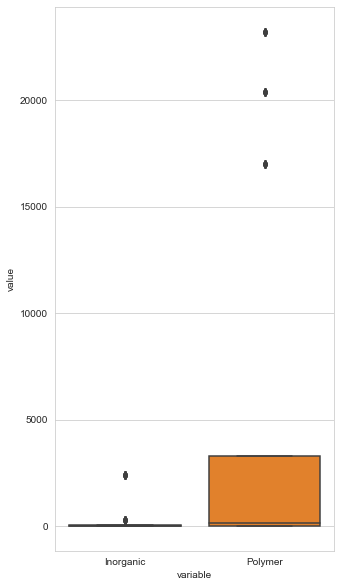

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 10))
sns.boxplot(x="variable", y="value", data=pd.melt(x_data))
plt.show()

위 그림에서 점으로 표현된 것이 outlier이다. outlier를 처리하는 방법으로는 아예 제거하는 방법 또는 평균이나 최빈값으로 대체하는 방법 등이 있다.

input data를 살펴보면 outlier의 개수가 feature마다 다르고 애초에 train size가 1000도 넘지 못할 정도로 매우 작다. 그리고 input_data에서 inorganic과 Polymer 값이 변화에 따른 MMM 값을 관찰한 결과 linear relationship을 가지는 간단한 모델이 이를 설명할 수 있음을 직관적으로 알 수 있다. 

따라서 우선은 outlier 처리 없이 학습을 진행해 보고 만약 학습이 잘 진행되지 않는다고 판단할 경우 outlier를 다른 값으로 대체하는 방식을 채택하기로 한다. 또한 categorical한 feature가 아니기 때문에 결측치는 최빈값이 아닌 평균값으로 대체하기로 한다.

In [29]:
# outlier mean value로 처리 (if necessary, not now)


# Model

우리가 하려는 일은 categorical하게 분류된 것이 아닌 어떤 특정한 float 값을 구하는 것이 목적이기 때문에 이 문제는 Regression으로 정의할 수 있다.

scikit learn에서 제공하는 Choosing the right estimator 그림(https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)에 따르면 우리가 사용할 수 있는 모델은 RidgeRegression과 SVR(kernal="rbf")가 있는데 위에서 언급했다시피 모델이 간단할 것으로 예측되기 때문에 우선은 RidgeRegression을 baseline model로 채택하였다.

~~input data로 사용한 두 feature의 중요도가 비슷하다는 것이 RidgeRegression일 거라는 주장을 뒷받침만할 또다른 근거가 될 수 있다(확인 필요)~~

In [30]:
# train set과 test set의 비율을 8:2로 나눠줌
# random_state를 고정시켜두어 반복해서 실험했을 때도 같은 결과가 나오게끔 해줌
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=777)

print(x_train.to_string(index=False))
print(x_test.to_string(index=False))
print(y_train.to_string(index=False))
print(y_test.to_string(index=False))

 Inorganic  Polymer
    47.200   201.00
    11.000     5.55
   280.000   201.00
     0.482 20400.00
    16.000 17000.00
     6.040     5.55
     0.670     5.55
     0.670   187.00
   280.000 20400.00
   280.000     0.13
    11.000 23200.00
     0.482   201.00
     0.670 17000.00
    47.200   156.00
    19.300 17000.00
     9.000 20400.00
     9.000   187.00
  2420.000     5.55
     9.000 17000.00
   280.000  3300.00
     6.040    76.20
    47.200 17000.00
  2420.000 20400.00
    47.200 20400.00
    11.000 17000.00
     9.000    13.06
   280.000    76.20
     5.460    76.20
    16.000   187.00
     5.460   201.00
    23.000     0.13
  2420.000 17000.00
    23.000    20.00
    16.000    52.00
    19.300     5.55
    23.000 17000.00
    47.200 23200.00
  2420.000    20.00
    16.000    13.06
    47.200    13.06
    47.200    20.00
     0.482    13.06
    23.000    13.06
    16.000   106.00
    16.000   156.00
   280.000    20.00
     9.000   154.00
     9.000  3300.00
     6.040   154.00


In [31]:
# Ridge regression
model = Ridge()

# Train

In [32]:
model.fit(x_train, y_train)

Ridge()

# Evaluation

In [33]:
train_score = model.score(x_train, y_train)
test_score = model.score(x_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.9975114756058587
Test score: 0.9975455398135871


예상대로 정확도가 매우 높게 나옴을 알 수 있다.

# Inference

In [34]:
# 우리가 위에서 모델을 평가할 때 사용한 test data를 이용해서 mmm 값을 구한 예시
# 현재 mmm의 예측 결과로 음수가 나오는 issue가 발생함 input_data로 추론해보건대 음수가 나오면 안될것 같은데 이거 해결 필요

y_pred = model.predict(x_test)
mmm_pred = np.hstack([x_test, y_pred])  # test data와 우리가 학습한 모델을 통해 예측된 mmm 값을 가로로 이어붙임
mmm_pred = pd.DataFrame(mmm_pred, columns=["inorganic", "Polymer", "precited MMM"])
print(mmm_pred.to_string(index=False))

 inorganic  Polymer  precited MMM
    16.000  3300.00   3293.572169
     0.670   156.00    138.780911
    16.000 20400.00  20439.677701
     5.460     5.55    -11.351609
    11.000    20.00      3.973704
    16.000    20.00      4.728534
    23.000    76.20     62.136825
     0.670    13.06     -4.544488
    23.000   201.00    187.273315
     5.460  3300.00   3291.980986
     0.482   156.00    138.752529
     6.040   106.00     89.456788
   280.000 17000.00  17070.365573
    11.000   187.00    171.423974
    19.300    20.00      5.226722
    11.000  3300.00   3292.817338
     0.482     5.55    -12.103118
     0.670   201.00    183.902241
     0.670   154.00    136.775519
     0.482 17000.00  17028.167827
     6.040 17000.00  17029.006896
     9.000    20.00      3.671772
     5.460   106.00     89.369227
    11.000    52.00     36.059983
     5.460   154.00    137.498646
     5.460     0.13    -16.786223
    11.000    76.20     60.325232
    23.000 23200.00  23248.283907
     0.482   1